# Import 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage
# from scipy.ndimage.interpolation import rotate
# from PIL import Image
%matplotlib inline

import tools

# Utilities

In [19]:
def load_image(name) :
    return ndimage.imread(var.get('dataDir') + cat + "/" + name)

# PrePare

In [3]:
# Prepare variables
V = tools.Vars()
# V.put('data_dir', os.getcwd() + "/../full_data_cell/")
# V.put('data_dir', os.getcwd() + "/../full_data_cell_bgrm/")
V.put('data_dir', os.getcwd() + "/../cell_unscale/")
V.put('cell_x', 140)
V.put('cell_y', 280)
V.put('test_set_size', 4096)
V.put('batch_size', 64)
V.put('learning_rate', 0.003)
V.put('training_iters', 200000)
V.put('display_step', 100)
V.put('save_step', 3000)
V.put('do_l2', False)
V.put('l2_rate', 0.0001)

In [4]:
# load Data
cats = os.listdir(V.get('data_dir'))
# cats.remove("others")
# cats.remove("shchoi")
# cats.remove(".ipynb_checkpoints")
# cats.remove("cell_xy.p")
cats.remove("PASS") # exclude PASS label
cats.remove("NORMAL") # exclude NORAML label
print cats
fList = []
cList = []
cDic = { cats[i] : i for i in range(len(cats)) }
for c in cats :
    fCat = os.listdir(V.get('data_dir') + c)
    for f in fCat :
#         if f.split('.')[-1] == "png" and f.split('_')[-2] == "O" :
        fList.append(V.get('data_dir') + c + "/" + f)
        cList.append(cDic[c])
V.put('n_output', len(cDic))
print "Loading Done"

OSError: [Errno 2] No such file or directory: '/notebooks/sd../cell_unscale/'

In [23]:
print len(fList)

47975


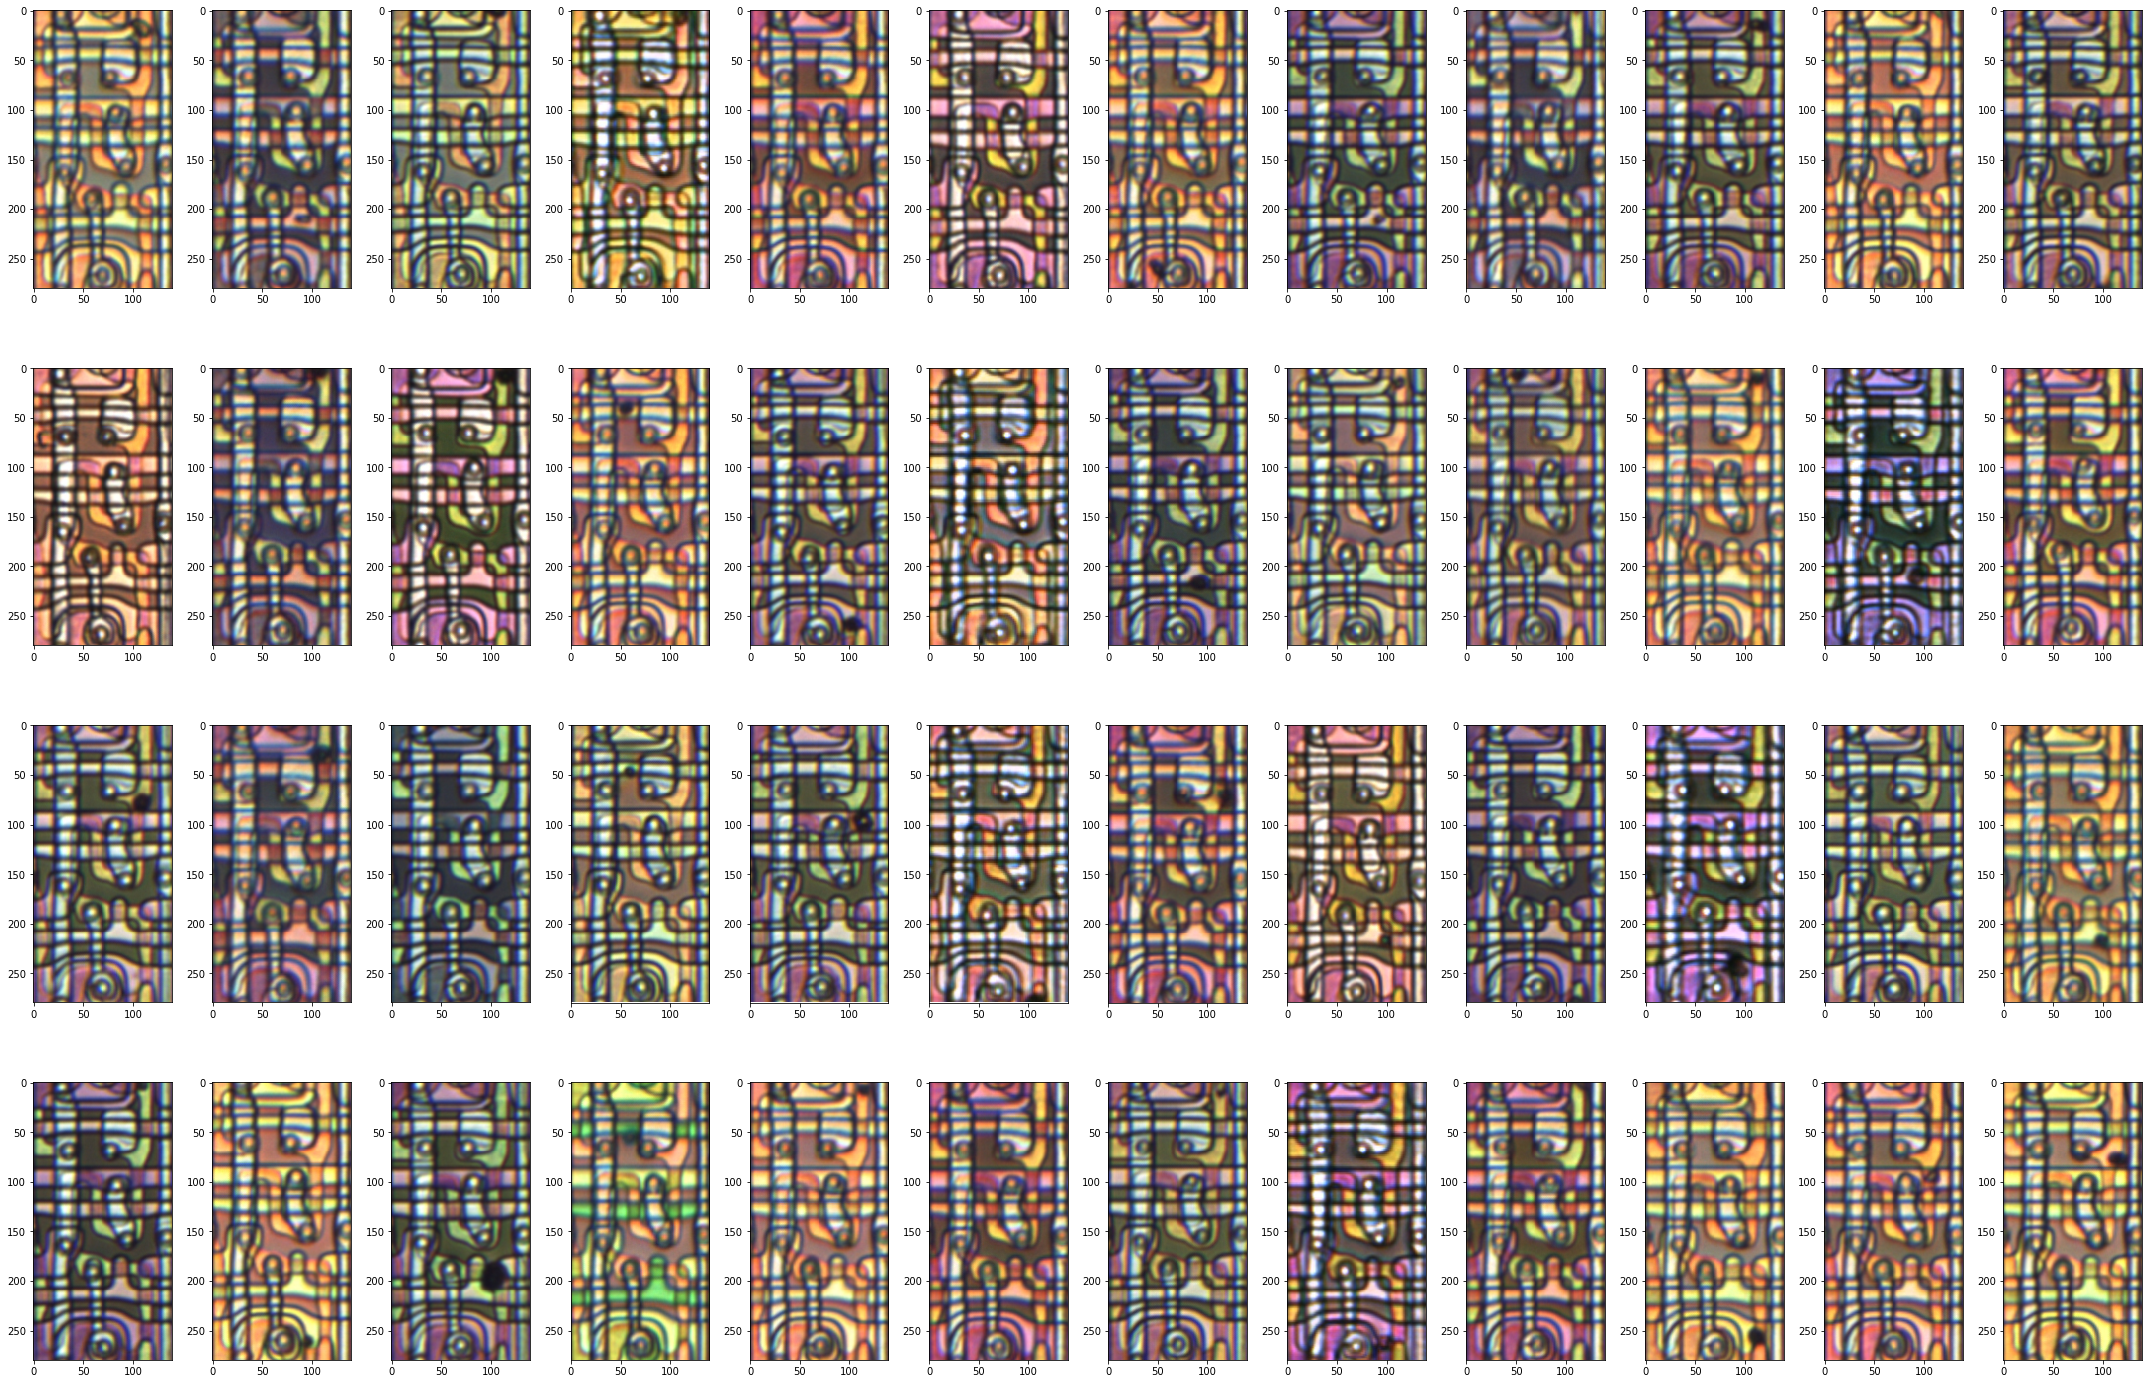

In [25]:
# visualize
# visual_cat = "CNT_NOT_OPEN_S"
visual_cat = "BLACK_SPOT"
fig, ax = plt.subplots(4, 12, figsize=(30, 20))
idxs = np.random.permutation(len(fList))
m = 0
for i in range(4):
    for j in range(12):
        while(cList[idxs[m]] != cDic[visual_cat]) :
            m += 1
#         n = 12*i + j
        f = fList[idxs[m]]
#         print cList[idxs[n]]
        ax[i,j].imshow(ndimage.imread(f))
        m += 1
plt.tight_layout()

In [11]:
print np.unique(cList)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21]


# Build Structure 

In [12]:
# Some Structure Function

def conv3_bn(layer_in, w, b, phase, momentum=0.99) :
    conv = tf.nn.conv2d(layer_in, w, strides=[1,1,1,1], padding='SAME')
    conv = tf.nn.bias_add(conv, b)
    bn = tf.layers.batch_normalization(conv, axis=3, center=True, scale=True, training=phase, momentum=momentum)
    return tf.nn.relu(bn)
        
def conv33pool2(layer_in, w1, b1, w2, b2, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w1, b1, phase)
        layer2 = conv3_bn(layer1, w2, b2, phase)
        pool = tf.nn.max_pool(layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return pool

def conv333pool2(layer_in, w1, b1, w2, b2, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w1, b1, phase)
        layer2 = conv3_bn(layer1, w2, b2, phase)
        layer3 = conv3_bn(layer2, w3, b3, phase)
        pool = tf.nn.max_pool(layer3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return pool

def conv33pool4(layer_in, w1, b1, w2, b2, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w1, b1, phase)
        layer2 = conv3_bn(layer1, w2, b2, phase)
        pool = tf.nn.max_pool(layer2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    return pool

def conv333pool5(layer_in, w1, b1, w2, b2, w3, b3, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w1, b1, phase)
        layer2 = conv3_bn(layer1, w2, b2, phase)
        layer3 = conv3_bn(layer2, w3, b3, phase)
        pool = tf.nn.max_pool(layer3, ksize=[1,5,5,1], strides=[1,5,5,1], padding='SAME')
    return pool

def conv3333pool8(layer_in, w1, b1, w2, b2, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w1, b1, phase)
        layer2 = conv3_bn(layer1, w2, b2, phase)
        layer3 = conv3_bn(layer2, w3, b3, phase)
        layer4 = conv3_bn(layer3, w4, b4, phase)
        pool = tf.nn.max_pool(layer4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return pool

def conv3pool_half(layer_in, w, b, phase, name_scope) :
    with tf.name_scope(name_scope) :
        layer1 = conv3_bn(layer_in, w, b, phase)
        pool = tf.nn.max_pool(layer1, ksize=[1,2,1,1], strides=[1,2,1,1], padding='SAME')
    return pool

In [13]:
# build pipeline
cell_x = V.get('cell_x')
cell_y = V.get('cell_y')
batch_size = V.get('batch_size')
test_set_size = V.get('test_set_size')
n_input = cell_y*cell_x
n_output = V.get('n_output')

all_images = tf.convert_to_tensor(fList, dtype=tf.string)
all_labels = tf.convert_to_tensor(cList, dtype=tf.uint8)

train_set_size = len(fList) - test_set_size
partitions = [0] * len(fList)
partitions[:test_set_size] = [1] * test_set_size
np.random.shuffle(partitions)

train_images, test_images = tf.dynamic_partition(all_images, partitions, 2)
train_labels, test_labels = tf.dynamic_partition(all_labels, partitions, 2)

train_input_queue = tf.train.slice_input_producer([train_images, train_labels], shuffle=True)
test_input_queue = tf.train.slice_input_producer([test_images, test_labels], shuffle=False)

file_content = tf.read_file(train_input_queue[0])
train_image = tf.image.decode_png(file_content)
train_label = train_input_queue[1]

file_content = tf.read_file(test_input_queue[0])
test_image = tf.image.decode_png(file_content)
test_label = test_input_queue[1]

train_image.set_shape([cell_y, cell_x, 3])
test_image.set_shape([cell_y, cell_x, 3])

train_image_batch, train_label_batch = tf.train.batch([train_image, train_label], batch_size = batch_size)
test_image_batch, test_label_batch = tf.train.batch([test_image, test_label], batch_size = batch_size)

# placeholder
x = tf.placeholder(tf.float32, [None, cell_y, cell_x, 3], name="x")
y = tf.placeholder(tf.uint8, [None], name="y")
y_hot = tf.one_hot(y, n_output, name="y_hot")
phase = tf.placeholder(tf.bool, name="phase")

# preprocessing
with tf.name_scope("Zero_Channel") :
    ch_mean = tf.reduce_mean(x, [1,2])
    ch_mean = tf.expand_dims(ch_mean, 1)
    ch_mean = tf.expand_dims(ch_mean, 2)
    ch_mean = tf.tile(ch_mean, [1, cell_y, cell_x, 1])
    x_std = x - ch_mean

AxesImage(54,36;334.8x217.44)


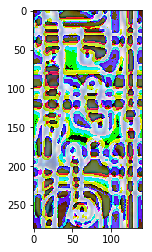

In [11]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

x_batch, y_batch = sess.run([train_image_batch, train_label_batch])
result = sess.run(x_std, feed_dict={x:x_batch})
print plt.imshow(result[3].astype(np.uint8))

In [13]:
# # 4 layer

# n_out = np.max(np.unique(y_data)) + 1
# n_in = X_data.shape[1]*X_data.shape[2]
# n_ch1 = 16
# n_ch2 = 32
# n_ch3 = 128
# W = {"w1" : tf.Variable(tf.truncated_normal([5, 5, 3, n_ch1], stddev=0.1)),
#     "w2" : tf.Variable(tf.truncated_normal([5, 5, n_ch1, n_ch2], stddev=0.1)),
#     "w3" : tf.Variable(tf.truncated_normal([14*14*n_ch2, n_ch3], stddev=0.1)),
#     "w4" : tf.Variable(tf.truncated_normal([n_ch3, n_out], stddev=0.1))}
# B = {"b1" : tf.Variable(tf.random_normal([n_ch1], stddev=0.1)),
#     "b2" : tf.Variable(tf.random_normal([n_ch2], stddev=0.1)),
#     "b3" : tf.Variable(tf.random_normal([n_ch3], stddev=0.1)),
#     "b4" : tf.Variable(tf.random_normal([n_out], stddev=0.1))}

# x = tf.placeholder(tf.float32, [None, 256, 256, 3])
# y = tf.placeholder(tf.uint8, [None])
# y_hot = tf.one_hot(y, n_out)

# with tf.name_scope("Crop") :
#     crop = tf.map_fn(lambda img: tf.random_crop(img, [224, 224, 3]), x)

# with tf.name_scope("Conv1") :
#     conv1 = tf.nn.conv2d(crop, W["w1"], strides=[1,1,1,1], padding='SAME')
#     mean, var = tf.nn.moments(conv1, [0,1,2])
#     conv1 = tf.nn.batch_normalization(conv1, mean, var, 0, 1, 0.001)
#     conv1 = tf.nn.relu(tf.nn.bias_add(conv1, B["b1"]))
#     pool1 = tf.nn.max_pool(conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')

# with tf.name_scope("Conv2") :
#     conv2 = tf.nn.conv2d(pool1, W["w2"], strides=[1,1,1,1], padding='SAME')
#     mean, var = tf.nn.moments(conv2, [0,1,2])
#     conv2 = tf.nn.batch_normalization(conv2, mean, var, 0, 1, 0.001)
#     conv2 = tf.nn.relu(tf.nn.bias_add(conv2, B["b2"]))
#     pool2 = tf.nn.max_pool(conv2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')

# with tf.name_scope("FC1") :
#     fc1 = tf.reshape(pool2, [-1, W["w3"].get_shape().as_list()[0]])
#     fc1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc1, W["w3"]), B["b3"]))

# with tf.name_scope("FC2") :
#     fc2 = tf.nn.bias_add(tf.matmul(fc1, W["w4"]), B["b4"])

# with tf.name_scope("Cost") :
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_hot))
# #     loss = loss + 0.0003*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
#     opt = tf.train.AdamOptimizer(learning_rate=0.003).minimize(loss)

# with tf.name_scope("Accuracy") :
#     corPred = tf.equal(tf.argmax(fc2, axis=1), tf.argmax(y_hot, axis=1))
#     acc = tf.reduce_mean(tf.cast(corPred, tf.float32))
    
# print "Structure build Complete"

In [14]:
# # 5 layer

# n_out = np.max(np.unique(y_data)) + 1
# n_in = X_data.shape[1]*X_data.shape[2]
# n_c1 = 8
# n_c2 = 16
# n_c3 = 32
# n_fc1 = 128
# W = {"c1_1" : tf.Variable(tf.truncated_normal([3, 3, 3, n_c1], stddev=0.1)),
#     "c1_2" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c1], stddev=0.1)),
#     "c2_1" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c2], stddev=0.1)),
#     "c2_2" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c2], stddev=0.1)),
#     "c3_1" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c3], stddev=0.1)),
#     "c3_2" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1)),
#     "fc1" : tf.Variable(tf.truncated_normal([8*8*n_c3, n_fc1], stddev=0.1)),
#     "fc2" : tf.Variable(tf.truncated_normal([n_fc1, n_out], stddev=0.1))}
# B = {"c1_1" : tf.Variable(tf.random_normal([n_c1], stddev=0.1)),
#     "c1_2" : tf.Variable(tf.random_normal([n_c1], stddev=0.1)),
#     "c2_1" : tf.Variable(tf.random_normal([n_c2], stddev=0.1)),
#     "c2_2" : tf.Variable(tf.random_normal([n_c2], stddev=0.1)),
#     "c3_1" : tf.Variable(tf.random_normal([n_c3], stddev=0.1)),
#     "c3_2" : tf.Variable(tf.random_normal([n_c3], stddev=0.1)),
#     "fc1" : tf.Variable(tf.random_normal([n_fc1], stddev=0.1)),
#     "fc2" : tf.Variable(tf.random_normal([n_out], stddev=0.1))}

# x = tf.placeholder(tf.float32, [None, 256, 256, 3])
# y = tf.placeholder(tf.uint8, [None])
# y_hot = tf.one_hot(y, n_out)

# pool1 = conv33pool4(x, W["c1_1"], B["c1_1"], W["c1_2"], B["c1_2"], "Conv1")
# pool2 = conv33pool4(pool1, W["c2_1"], B["c2_1"], W["c2_2"], B["c2_2"], "Conv2")
# pool3 = conv33pool2(pool2, W["c3_1"], B["c3_1"], W["c3_2"], B["c3_2"], "Conv3")

# with tf.name_scope("FC1") :
#     fc1 = tf.reshape(pool3, [-1, W["fc1"].get_shape().as_list()[0]])
#     fc1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc1, W["fc1"]), B["fc1"]))

# with tf.name_scope("FC2") :
#     fc2 = tf.nn.bias_add(tf.matmul(fc1, W["fc2"]), B["fc2"])

# with tf.name_scope("Cost") :
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_hot))
#     loss = loss + 0.1*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
#     opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# with tf.name_scope("Accuracy") :
#     corPred = tf.equal(tf.argmax(fc2, axis=1), tf.argmax(y_hot, axis=1))
#     acc = tf.reduce_mean(tf.cast(corPred, tf.float32))
    
# print "Structure build Complete"

In [15]:
# # 7 layer

# n_out = np.max(np.unique(y_data)) + 1
# n_in = X_data.shape[1]*X_data.shape[2]
# n_c1 = 8
# n_c2 = 16
# n_c3 = 16
# n_c4 = 32
# n_c5 = 64
# n_fc1 = 128
# W = {"c1_1" : tf.Variable(tf.truncated_normal([3, 3, 3, n_c1], stddev=0.1)),
#     "c1_2" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c1], stddev=0.1)),
#     "c2_1" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c2], stddev=0.1)),
#     "c2_2" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c2], stddev=0.1)),
#     "c3_1" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c3], stddev=0.1)),
#     "c3_2" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1)),
#     "c4_1" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c4], stddev=0.1)),
#     "c4_2" : tf.Variable(tf.truncated_normal([3, 3, n_c4, n_c4], stddev=0.1)),
#     "c5_1" : tf.Variable(tf.truncated_normal([3, 3, n_c4, n_c5], stddev=0.1)),
#     "c5_2" : tf.Variable(tf.truncated_normal([3, 3, n_c5, n_c5], stddev=0.1)),
#     "fc1" : tf.Variable(tf.truncated_normal([8*8*n_c5, n_fc1], stddev=0.1)),
#     "fc2" : tf.Variable(tf.truncated_normal([n_fc1, n_out], stddev=0.1))}
# B = {"c1_1" : tf.Variable(tf.random_normal([n_c1], stddev=0.1)),
#     "c1_2" : tf.Variable(tf.random_normal([n_c1], stddev=0.1)),
#     "c2_1" : tf.Variable(tf.random_normal([n_c2], stddev=0.1)),
#     "c2_2" : tf.Variable(tf.random_normal([n_c2], stddev=0.1)),
#     "c3_1" : tf.Variable(tf.random_normal([n_c3], stddev=0.1)),
#     "c3_2" : tf.Variable(tf.random_normal([n_c3], stddev=0.1)),
#     "c4_1" : tf.Variable(tf.random_normal([n_c4], stddev=0.1)),
#     "c4_2" : tf.Variable(tf.random_normal([n_c4], stddev=0.1)),
#     "c5_1" : tf.Variable(tf.random_normal([n_c5], stddev=0.1)),
#     "c5_2" : tf.Variable(tf.random_normal([n_c5], stddev=0.1)),
#     "fc1" : tf.Variable(tf.random_normal([n_fc1], stddev=0.1)),
#     "fc2" : tf.Variable(tf.random_normal([n_out], stddev=0.1))}

# x = tf.placeholder(tf.float32, [None, 256, 256, 3])
# y = tf.placeholder(tf.uint8, [None])
# y_hot = tf.one_hot(y, n_out)

# pool1 = conv33pool2(x, W["c1_1"], B["c1_1"], W["c1_2"], B["c1_2"], "Conv1")
# pool2 = conv33pool2(pool1, W["c2_1"], B["c2_1"], W["c2_2"], B["c2_2"], "Conv2")
# pool3 = conv33pool2(pool2, W["c3_1"], B["c3_1"], W["c3_2"], B["c3_2"], "Conv3")
# pool4 = conv333pool2(pool3, W["c4_1"], B["c4_1"], W["c4_2"], B["c4_2"], "Conv4")
# pool5 = conv333pool2(pool4, W["c5_1"], B["c5_1"], W["c5_2"], B["c5_2"], "Conv5")

# with tf.name_scope("FC1") :
#     fc1 = tf.reshape(pool5, [-1, W["fc1"].get_shape().as_list()[0]])
#     fc1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc1, W["fc1"]), B["fc1"]))

# with tf.name_scope("FC2") :
#     fc2 = tf.nn.bias_add(tf.matmul(fc1, W["fc2"]), B["fc2"])

# with tf.name_scope("Cost") :
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_hot))
#     loss = loss + 0.01*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
#     opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# with tf.name_scope("Accuracy") :
#     corPred = tf.equal(tf.argmax(fc2, axis=1), tf.argmax(y_hot, axis=1))
#     acc = tf.reduce_mean(tf.cast(corPred, tf.float32))
    
# print "Structure build Complete"

In [14]:
# 5 layers

do_l2 = V.get('do_l2')
learning_rate = V.get('learning_rate')
l2_rate = V.get('l2_rate')
n_c1 = 32
n_c2 = 64
n_c3 = 128
n_c4 = 128
n_fc1 = 512
n_output = V.get('n_output')

with tf.name_scope("Weight") :
    W = {"c1_1" : tf.Variable(tf.truncated_normal([3, 3, 3, n_c1], stddev=0.1), name="w_c1_1"),
        "c1_2" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c1], stddev=0.1), name="w_c1_2"),
        "c2_1" : tf.Variable(tf.truncated_normal([3, 3, n_c1, n_c2], stddev=0.1), name="w_c2_1"),
        "c2_2" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c2], stddev=0.1), name="w_c2_2"),
        "c3_1" : tf.Variable(tf.truncated_normal([3, 3, n_c2, n_c3], stddev=0.1), name="w_c3_1"),
        "c3_2" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1), name="w_c3_2"),
        "c3_3" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c3], stddev=0.1), name="w_c3_3"),
        "c4_1" : tf.Variable(tf.truncated_normal([3, 3, n_c3, n_c4], stddev=0.1), name="w_c4_1"),
        "fc1" : tf.Variable(tf.truncated_normal([7*7*n_c4, n_fc1], stddev=0.1), name="w_fc1"),
        "out" : tf.Variable(tf.truncated_normal([n_fc1, n_output], stddev=0.1), name="w_out")}
    
with tf.name_scope("Bias") :
    B = {"c1_1" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_1"),
        "c1_2" : tf.Variable(tf.random_normal([n_c1], stddev=0.1), name="b_c1_2"),
        "c2_1" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_1"),
        "c2_2" : tf.Variable(tf.random_normal([n_c2], stddev=0.1), name="b_c2_2"),
        "c3_1" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_1"),
        "c3_2" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_2"),
        "c3_3" : tf.Variable(tf.random_normal([n_c3], stddev=0.1), name="b_c3_3"),
        "c4_1" : tf.Variable(tf.random_normal([n_c4], stddev=0.1), name="b_c4_1"),
        "fc1" : tf.Variable(tf.random_normal([n_fc1], stddev=0.1), name="b_fc1"),
        "out" : tf.Variable(tf.random_normal([n_output], stddev=0.1), name="b_out")}

pool1 = conv33pool2(x_std, W["c1_1"], B["c1_1"], W["c1_2"], B["c1_2"], phase, "Conv1")
pool2 = conv33pool2(pool1, W["c2_1"], B["c2_1"], W["c2_2"], B["c2_2"], phase, "Conv2")
pool3 = conv333pool5(pool2, W["c3_1"], B["c3_1"], W["c3_2"], B["c3_2"], W["c3_3"], B["c3_3"], phase, "Conv3")
pool4 = conv3pool_half(pool3, W["c4_1"], B["c4_1"], phase, "Half")

with tf.name_scope("FC1") :
    fc1 = tf.reshape(pool4, [-1, W["fc1"].get_shape().as_list()[0]])
    fc1 = tf.nn.bias_add(tf.matmul(fc1, W["fc1"]), B["fc1"])
    fc1 = tf.layers.batch_normalization(fc1, axis=1, center=True, scale=True, training=phase)
    fc1 = tf.nn.relu(fc1)

with tf.name_scope("OUT") :
    fc2 = tf.nn.bias_add(tf.matmul(fc1, W["out"]), B["out"])

with tf.name_scope("Cost") :
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_hot))
    if do_l2 :
        loss = loss + l2_rate*tf.add_n([ tf.nn.l2_loss(w) for w in W.values() ]) # L2 regularization
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops) :
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope("Accuracy") :
    corPred = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_hot, 1))
    acc = tf.reduce_mean(tf.cast(corPred, tf.float32))
    
print "Structure build Complete"


Structure build Complete


# TensorBoard

In [18]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
print "Session Created"

boardDir = "/notebooks/board/SD/"
# expTag = "CNN_Cell"
expTag = "CNN_Cell_bgrm"
expName = "Layer5_x3_e003_1"
summary_writer = tf.summary.FileWriter("{:}{:}/{:}/".format(boardDir, expTag, expName), sess.graph)
V.put('model_save_path', "./model/{:}/{:}/save".format(expTag, expName))

Session Created


In [17]:
os.system("rm -r -f {}".format(boardDir + expTag + expName))

0

# Run

In [19]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

model_save_path = V.get('model_save_path')
training_iters = V.get('training_iters')
display_step = V.get('display_step')
save_step = V.get('save_step')
batch_size = V.get('batch_size')
train_batch_num = train_set_size/batch_size
test_batch_num = test_set_size/batch_size

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

saver = tf.train.Saver()

print batch_size, train_batch_num, test_batch_num

print "Training..."
for iteration in range(training_iters):
    x_batch, y_batch = sess.run([train_image_batch, train_label_batch])
    sess.run(opt, feed_dict={x:x_batch, y:y_batch, phase:True})
    
    if (iteration+1) % save_step == 0 :
        saver.save(sess, model_save_path, global_step=iteration+1)
        
    if (iteration+1) % display_step == 0 :
        summary = tf.Summary()
        
        train_cost, train_acc = sess.run([loss, acc], feed_dict={x:x_batch, y:y_batch, phase:False})
        summary.value.add(tag="train_cost", simple_value=train_cost)
        summary.value.add(tag="train_accuracy", simple_value=train_acc)

        test_cost = 0
        test_acc = 0
        for i in range(test_batch_num) :
            x_batch, y_batch = sess.run([test_image_batch, test_label_batch])
            test_cost_temp, test_acc_temp = sess.run([loss, acc], feed_dict={x:x_batch, y:y_batch, phase:False})
            test_cost += test_cost_temp*batch_size
            test_acc += test_acc_temp*batch_size
        test_cost = test_cost/test_set_size
        test_acc = test_acc/test_set_size
        summary.value.add(tag="test_cost", simple_value=test_cost)
        summary.value.add(tag="test_accuracy", simple_value=test_acc)
        summary_writer.add_summary(summary, iteration)
        
        print "iter: {:06d}/{:06d} TrainCost : {:.3f} TestCost : {:.3f} TrainAcc : {:.3f} TestAcc : {:.3f}".format(iteration+1, training_iters, train_cost, test_cost, train_acc, test_acc)

coord.request_stop()
coord.join(threads)

64 687 62
Training...
iter: 000100/200000 TrainCost : 11.962 TestCost : 11.824 TrainAcc : 0.453 TestAcc : 0.328
iter: 000200/200000 TrainCost : 4.605 TestCost : 4.769 TrainAcc : 0.109 TestAcc : 0.161
iter: 000300/200000 TrainCost : 2.625 TestCost : 2.833 TrainAcc : 0.469 TestAcc : 0.453
iter: 000400/200000 TrainCost : 2.275 TestCost : 2.171 TrainAcc : 0.328 TestAcc : 0.431
iter: 000500/200000 TrainCost : 1.577 TestCost : 1.509 TrainAcc : 0.547 TestAcc : 0.518
iter: 000600/200000 TrainCost : 1.461 TestCost : 1.567 TrainAcc : 0.547 TestAcc : 0.549
iter: 000700/200000 TrainCost : 1.500 TestCost : 1.335 TrainAcc : 0.609 TestAcc : 0.610
iter: 000800/200000 TrainCost : 1.387 TestCost : 1.640 TrainAcc : 0.609 TestAcc : 0.507
iter: 000900/200000 TrainCost : 1.742 TestCost : 1.435 TrainAcc : 0.562 TestAcc : 0.589
iter: 001000/200000 TrainCost : 1.141 TestCost : 1.415 TrainAcc : 0.641 TestAcc : 0.545
iter: 001100/200000 TrainCost : 0.935 TestCost : 1.220 TrainAcc : 0.703 TestAcc : 0.641
iter: 00

iter: 009400/200000 TrainCost : 0.121 TestCost : 1.902 TrainAcc : 0.953 TestAcc : 0.689
iter: 009500/200000 TrainCost : 0.171 TestCost : 1.912 TrainAcc : 0.969 TestAcc : 0.684
iter: 009600/200000 TrainCost : 0.126 TestCost : 2.116 TrainAcc : 0.953 TestAcc : 0.669
iter: 009700/200000 TrainCost : 0.101 TestCost : 2.217 TrainAcc : 0.969 TestAcc : 0.645
iter: 009800/200000 TrainCost : 0.059 TestCost : 1.848 TrainAcc : 0.984 TestAcc : 0.684
iter: 009900/200000 TrainCost : 0.043 TestCost : 2.348 TrainAcc : 0.984 TestAcc : 0.658
iter: 010000/200000 TrainCost : 0.123 TestCost : 2.060 TrainAcc : 0.953 TestAcc : 0.683
iter: 010100/200000 TrainCost : 0.165 TestCost : 2.364 TrainAcc : 0.953 TestAcc : 0.663
iter: 010200/200000 TrainCost : 0.965 TestCost : 2.656 TrainAcc : 0.688 TestAcc : 0.536
iter: 010300/200000 TrainCost : 0.237 TestCost : 2.302 TrainAcc : 0.922 TestAcc : 0.684
iter: 010400/200000 TrainCost : 0.085 TestCost : 1.861 TrainAcc : 0.969 TestAcc : 0.685
iter: 010500/200000 TrainCost : 

iter: 018800/200000 TrainCost : 0.062 TestCost : 2.301 TrainAcc : 0.953 TestAcc : 0.665
iter: 018900/200000 TrainCost : 0.119 TestCost : 2.380 TrainAcc : 0.953 TestAcc : 0.676
iter: 019000/200000 TrainCost : 0.046 TestCost : 2.947 TrainAcc : 0.984 TestAcc : 0.665
iter: 019100/200000 TrainCost : 0.093 TestCost : 3.251 TrainAcc : 0.953 TestAcc : 0.683
iter: 019200/200000 TrainCost : 0.067 TestCost : 2.131 TrainAcc : 0.953 TestAcc : 0.659
iter: 019300/200000 TrainCost : 0.046 TestCost : 2.596 TrainAcc : 0.984 TestAcc : 0.683
iter: 019400/200000 TrainCost : 0.038 TestCost : 2.598 TrainAcc : 0.984 TestAcc : 0.682
iter: 019500/200000 TrainCost : 0.063 TestCost : 2.456 TrainAcc : 0.969 TestAcc : 0.662
iter: 019600/200000 TrainCost : 0.047 TestCost : 2.515 TrainAcc : 0.984 TestAcc : 0.686
iter: 019700/200000 TrainCost : 0.065 TestCost : 2.495 TrainAcc : 0.984 TestAcc : 0.675
iter: 019800/200000 TrainCost : 0.033 TestCost : 2.442 TrainAcc : 0.984 TestAcc : 0.668
iter: 019900/200000 TrainCost : 

iter: 028200/200000 TrainCost : 0.062 TestCost : 2.684 TrainAcc : 0.969 TestAcc : 0.696
iter: 028300/200000 TrainCost : 0.035 TestCost : 2.653 TrainAcc : 0.969 TestAcc : 0.633
iter: 028400/200000 TrainCost : 0.002 TestCost : 2.448 TrainAcc : 1.000 TestAcc : 0.678
iter: 028500/200000 TrainCost : 0.165 TestCost : 3.273 TrainAcc : 0.938 TestAcc : 0.692
iter: 028600/200000 TrainCost : 0.042 TestCost : 2.660 TrainAcc : 0.984 TestAcc : 0.685
iter: 028700/200000 TrainCost : 0.031 TestCost : 2.841 TrainAcc : 0.984 TestAcc : 0.667
iter: 028800/200000 TrainCost : 0.009 TestCost : 3.597 TrainAcc : 1.000 TestAcc : 0.670
iter: 028900/200000 TrainCost : 0.050 TestCost : 3.593 TrainAcc : 0.984 TestAcc : 0.634
iter: 029000/200000 TrainCost : 0.145 TestCost : 2.997 TrainAcc : 0.969 TestAcc : 0.686
iter: 029100/200000 TrainCost : 0.025 TestCost : 2.555 TrainAcc : 1.000 TestAcc : 0.693
iter: 029200/200000 TrainCost : 0.032 TestCost : 2.682 TrainAcc : 0.969 TestAcc : 0.682
iter: 029300/200000 TrainCost : 

iter: 037600/200000 TrainCost : 0.007 TestCost : 4.055 TrainAcc : 1.000 TestAcc : 0.673
iter: 037700/200000 TrainCost : 0.030 TestCost : 2.767 TrainAcc : 0.984 TestAcc : 0.690
iter: 037800/200000 TrainCost : 0.027 TestCost : 3.240 TrainAcc : 0.984 TestAcc : 0.689
iter: 037900/200000 TrainCost : 0.147 TestCost : 3.024 TrainAcc : 0.969 TestAcc : 0.639
iter: 038000/200000 TrainCost : 0.058 TestCost : 3.625 TrainAcc : 0.984 TestAcc : 0.692
iter: 038100/200000 TrainCost : 0.098 TestCost : 3.418 TrainAcc : 0.969 TestAcc : 0.667
iter: 038200/200000 TrainCost : 0.001 TestCost : 3.190 TrainAcc : 1.000 TestAcc : 0.676
iter: 038300/200000 TrainCost : 0.035 TestCost : 3.246 TrainAcc : 0.984 TestAcc : 0.672
iter: 038400/200000 TrainCost : 0.035 TestCost : 3.028 TrainAcc : 0.984 TestAcc : 0.671
iter: 038500/200000 TrainCost : 0.035 TestCost : 3.259 TrainAcc : 0.984 TestAcc : 0.694
iter: 038600/200000 TrainCost : 0.074 TestCost : 2.821 TrainAcc : 0.969 TestAcc : 0.665
iter: 038700/200000 TrainCost : 

iter: 047000/200000 TrainCost : 0.003 TestCost : 3.439 TrainAcc : 1.000 TestAcc : 0.667
iter: 047100/200000 TrainCost : 0.053 TestCost : 3.447 TrainAcc : 0.984 TestAcc : 0.693
iter: 047200/200000 TrainCost : 0.040 TestCost : 3.170 TrainAcc : 0.984 TestAcc : 0.647
iter: 047300/200000 TrainCost : 0.051 TestCost : 3.404 TrainAcc : 0.984 TestAcc : 0.679
iter: 047400/200000 TrainCost : 0.001 TestCost : 3.662 TrainAcc : 1.000 TestAcc : 0.693
iter: 047500/200000 TrainCost : 0.066 TestCost : 3.269 TrainAcc : 0.984 TestAcc : 0.667
iter: 047600/200000 TrainCost : 0.066 TestCost : 3.952 TrainAcc : 0.984 TestAcc : 0.683
iter: 047700/200000 TrainCost : 0.008 TestCost : 3.868 TrainAcc : 1.000 TestAcc : 0.693
iter: 047800/200000 TrainCost : 0.030 TestCost : 3.148 TrainAcc : 0.984 TestAcc : 0.699
iter: 047900/200000 TrainCost : 0.024 TestCost : 3.465 TrainAcc : 1.000 TestAcc : 0.685
iter: 048000/200000 TrainCost : 0.065 TestCost : 3.318 TrainAcc : 0.984 TestAcc : 0.659
iter: 048100/200000 TrainCost : 

iter: 056400/200000 TrainCost : 0.299 TestCost : 5.163 TrainAcc : 0.938 TestAcc : 0.673
iter: 056500/200000 TrainCost : 0.022 TestCost : 4.319 TrainAcc : 0.984 TestAcc : 0.662
iter: 056600/200000 TrainCost : 0.016 TestCost : 3.215 TrainAcc : 1.000 TestAcc : 0.671
iter: 056700/200000 TrainCost : 0.012 TestCost : 3.504 TrainAcc : 1.000 TestAcc : 0.670
iter: 056800/200000 TrainCost : 0.090 TestCost : 3.841 TrainAcc : 0.969 TestAcc : 0.673
iter: 056900/200000 TrainCost : 0.064 TestCost : 3.797 TrainAcc : 0.984 TestAcc : 0.623
iter: 057000/200000 TrainCost : 0.059 TestCost : 4.144 TrainAcc : 0.984 TestAcc : 0.681
iter: 057100/200000 TrainCost : 0.053 TestCost : 3.442 TrainAcc : 0.984 TestAcc : 0.676
iter: 057200/200000 TrainCost : 0.001 TestCost : 3.402 TrainAcc : 1.000 TestAcc : 0.697
iter: 057300/200000 TrainCost : 0.021 TestCost : 3.032 TrainAcc : 1.000 TestAcc : 0.686
iter: 057400/200000 TrainCost : 0.003 TestCost : 3.382 TrainAcc : 1.000 TestAcc : 0.676
iter: 057500/200000 TrainCost : 

iter: 065800/200000 TrainCost : 0.022 TestCost : 3.319 TrainAcc : 0.984 TestAcc : 0.669
iter: 065900/200000 TrainCost : 0.018 TestCost : 3.514 TrainAcc : 1.000 TestAcc : 0.681
iter: 066000/200000 TrainCost : 0.000 TestCost : 3.994 TrainAcc : 1.000 TestAcc : 0.695
iter: 066100/200000 TrainCost : 0.000 TestCost : 3.241 TrainAcc : 1.000 TestAcc : 0.683
iter: 066200/200000 TrainCost : 0.002 TestCost : 3.471 TrainAcc : 1.000 TestAcc : 0.679
iter: 066300/200000 TrainCost : 0.001 TestCost : 3.410 TrainAcc : 1.000 TestAcc : 0.690
iter: 066400/200000 TrainCost : 0.218 TestCost : 4.012 TrainAcc : 0.922 TestAcc : 0.675
iter: 066500/200000 TrainCost : 0.035 TestCost : 4.069 TrainAcc : 0.984 TestAcc : 0.694
iter: 066600/200000 TrainCost : 0.032 TestCost : 3.180 TrainAcc : 0.984 TestAcc : 0.690
iter: 066700/200000 TrainCost : 0.035 TestCost : 3.261 TrainAcc : 0.984 TestAcc : 0.626
iter: 066800/200000 TrainCost : 0.029 TestCost : 3.572 TrainAcc : 0.984 TestAcc : 0.672
iter: 066900/200000 TrainCost : 

iter: 075200/200000 TrainCost : 0.039 TestCost : 3.693 TrainAcc : 0.984 TestAcc : 0.685
iter: 075300/200000 TrainCost : 0.000 TestCost : 3.735 TrainAcc : 1.000 TestAcc : 0.689
iter: 075400/200000 TrainCost : 0.009 TestCost : 3.420 TrainAcc : 1.000 TestAcc : 0.680
iter: 075500/200000 TrainCost : 0.036 TestCost : 3.491 TrainAcc : 0.984 TestAcc : 0.669
iter: 075600/200000 TrainCost : 0.087 TestCost : 3.672 TrainAcc : 0.953 TestAcc : 0.683
iter: 075700/200000 TrainCost : 0.000 TestCost : 4.105 TrainAcc : 1.000 TestAcc : 0.694
iter: 075800/200000 TrainCost : 0.003 TestCost : 4.230 TrainAcc : 1.000 TestAcc : 0.685
iter: 075900/200000 TrainCost : 0.004 TestCost : 4.350 TrainAcc : 1.000 TestAcc : 0.695
iter: 076000/200000 TrainCost : 0.034 TestCost : 3.907 TrainAcc : 0.984 TestAcc : 0.678
iter: 076100/200000 TrainCost : 0.076 TestCost : 3.205 TrainAcc : 0.984 TestAcc : 0.675
iter: 076200/200000 TrainCost : 0.000 TestCost : 3.983 TrainAcc : 1.000 TestAcc : 0.696
iter: 076300/200000 TrainCost : 

iter: 084600/200000 TrainCost : 0.037 TestCost : 4.223 TrainAcc : 0.984 TestAcc : 0.698
iter: 084700/200000 TrainCost : 0.000 TestCost : 4.830 TrainAcc : 1.000 TestAcc : 0.691
iter: 084800/200000 TrainCost : 0.000 TestCost : 4.086 TrainAcc : 1.000 TestAcc : 0.684
iter: 084900/200000 TrainCost : 0.002 TestCost : 4.460 TrainAcc : 1.000 TestAcc : 0.681
iter: 085000/200000 TrainCost : 0.000 TestCost : 3.607 TrainAcc : 1.000 TestAcc : 0.686
iter: 085100/200000 TrainCost : 0.000 TestCost : 3.596 TrainAcc : 1.000 TestAcc : 0.690
iter: 085200/200000 TrainCost : 0.034 TestCost : 3.337 TrainAcc : 0.984 TestAcc : 0.685
iter: 085300/200000 TrainCost : 0.000 TestCost : 5.175 TrainAcc : 1.000 TestAcc : 0.693
iter: 085400/200000 TrainCost : 0.061 TestCost : 4.800 TrainAcc : 0.984 TestAcc : 0.699
iter: 085500/200000 TrainCost : 0.001 TestCost : 4.334 TrainAcc : 1.000 TestAcc : 0.689
iter: 085600/200000 TrainCost : 0.000 TestCost : 3.851 TrainAcc : 1.000 TestAcc : 0.683
iter: 085700/200000 TrainCost : 

iter: 094000/200000 TrainCost : 0.004 TestCost : 4.834 TrainAcc : 1.000 TestAcc : 0.691
iter: 094100/200000 TrainCost : 0.000 TestCost : 5.200 TrainAcc : 1.000 TestAcc : 0.694
iter: 094200/200000 TrainCost : 0.075 TestCost : 4.760 TrainAcc : 0.969 TestAcc : 0.688
iter: 094300/200000 TrainCost : 0.000 TestCost : 4.362 TrainAcc : 1.000 TestAcc : 0.695
iter: 094400/200000 TrainCost : 0.013 TestCost : 4.071 TrainAcc : 0.984 TestAcc : 0.681
iter: 094500/200000 TrainCost : 0.000 TestCost : 4.234 TrainAcc : 1.000 TestAcc : 0.696
iter: 094600/200000 TrainCost : 0.085 TestCost : 3.840 TrainAcc : 0.969 TestAcc : 0.669
iter: 094700/200000 TrainCost : 0.000 TestCost : 4.493 TrainAcc : 1.000 TestAcc : 0.698
iter: 094800/200000 TrainCost : 0.068 TestCost : 4.371 TrainAcc : 0.953 TestAcc : 0.685
iter: 094900/200000 TrainCost : 0.000 TestCost : 4.421 TrainAcc : 1.000 TestAcc : 0.692
iter: 095000/200000 TrainCost : 0.007 TestCost : 3.204 TrainAcc : 1.000 TestAcc : 0.670
iter: 095100/200000 TrainCost : 

iter: 103400/200000 TrainCost : 0.034 TestCost : 3.596 TrainAcc : 0.984 TestAcc : 0.685
iter: 103500/200000 TrainCost : 0.000 TestCost : 3.968 TrainAcc : 1.000 TestAcc : 0.696
iter: 103600/200000 TrainCost : 0.076 TestCost : 5.178 TrainAcc : 0.969 TestAcc : 0.689
iter: 103700/200000 TrainCost : 0.039 TestCost : 4.642 TrainAcc : 0.984 TestAcc : 0.694
iter: 103800/200000 TrainCost : 0.000 TestCost : 4.305 TrainAcc : 1.000 TestAcc : 0.689
iter: 103900/200000 TrainCost : 0.006 TestCost : 3.811 TrainAcc : 1.000 TestAcc : 0.641
iter: 104000/200000 TrainCost : 0.000 TestCost : 3.993 TrainAcc : 1.000 TestAcc : 0.683
iter: 104100/200000 TrainCost : 0.051 TestCost : 4.457 TrainAcc : 0.969 TestAcc : 0.680
iter: 104200/200000 TrainCost : 0.019 TestCost : 4.205 TrainAcc : 1.000 TestAcc : 0.689
iter: 104300/200000 TrainCost : 0.019 TestCost : 4.706 TrainAcc : 1.000 TestAcc : 0.697
iter: 104400/200000 TrainCost : 0.037 TestCost : 3.810 TrainAcc : 0.984 TestAcc : 0.677
iter: 104500/200000 TrainCost : 

iter: 112800/200000 TrainCost : 0.000 TestCost : 4.857 TrainAcc : 1.000 TestAcc : 0.689
iter: 112900/200000 TrainCost : 0.033 TestCost : 4.143 TrainAcc : 0.984 TestAcc : 0.683
iter: 113000/200000 TrainCost : 0.019 TestCost : 4.067 TrainAcc : 1.000 TestAcc : 0.684
iter: 113100/200000 TrainCost : 0.000 TestCost : 4.594 TrainAcc : 1.000 TestAcc : 0.697
iter: 113200/200000 TrainCost : 0.070 TestCost : 4.705 TrainAcc : 0.984 TestAcc : 0.646
iter: 113300/200000 TrainCost : 0.001 TestCost : 4.270 TrainAcc : 1.000 TestAcc : 0.660
iter: 113400/200000 TrainCost : 0.000 TestCost : 4.710 TrainAcc : 1.000 TestAcc : 0.679
iter: 113500/200000 TrainCost : 0.033 TestCost : 4.905 TrainAcc : 0.984 TestAcc : 0.689
iter: 113600/200000 TrainCost : 0.000 TestCost : 4.297 TrainAcc : 1.000 TestAcc : 0.697
iter: 113700/200000 TrainCost : 0.003 TestCost : 3.644 TrainAcc : 1.000 TestAcc : 0.681
iter: 113800/200000 TrainCost : 0.000 TestCost : 4.624 TrainAcc : 1.000 TestAcc : 0.700
iter: 113900/200000 TrainCost : 

iter: 122200/200000 TrainCost : 0.000 TestCost : 5.157 TrainAcc : 1.000 TestAcc : 0.695
iter: 122300/200000 TrainCost : 0.000 TestCost : 3.940 TrainAcc : 1.000 TestAcc : 0.693
iter: 122400/200000 TrainCost : 0.000 TestCost : 4.267 TrainAcc : 1.000 TestAcc : 0.705
iter: 122500/200000 TrainCost : 0.001 TestCost : 4.071 TrainAcc : 1.000 TestAcc : 0.695
iter: 122600/200000 TrainCost : 0.033 TestCost : 4.358 TrainAcc : 0.984 TestAcc : 0.696
iter: 122700/200000 TrainCost : 0.044 TestCost : 5.095 TrainAcc : 0.984 TestAcc : 0.700
iter: 122800/200000 TrainCost : 0.000 TestCost : 5.540 TrainAcc : 1.000 TestAcc : 0.699
iter: 122900/200000 TrainCost : 0.035 TestCost : 5.496 TrainAcc : 0.984 TestAcc : 0.674
iter: 123000/200000 TrainCost : 0.008 TestCost : 4.370 TrainAcc : 1.000 TestAcc : 0.679
iter: 123100/200000 TrainCost : 0.000 TestCost : 4.451 TrainAcc : 1.000 TestAcc : 0.691
iter: 123200/200000 TrainCost : 0.000 TestCost : 4.180 TrainAcc : 1.000 TestAcc : 0.696
iter: 123300/200000 TrainCost : 

iter: 131600/200000 TrainCost : 0.037 TestCost : 5.538 TrainAcc : 0.984 TestAcc : 0.695
iter: 131700/200000 TrainCost : 0.044 TestCost : 4.819 TrainAcc : 0.984 TestAcc : 0.697
iter: 131800/200000 TrainCost : 0.065 TestCost : 3.733 TrainAcc : 0.984 TestAcc : 0.672
iter: 131900/200000 TrainCost : 0.012 TestCost : 4.170 TrainAcc : 1.000 TestAcc : 0.681
iter: 132000/200000 TrainCost : 0.034 TestCost : 4.635 TrainAcc : 0.984 TestAcc : 0.690
iter: 132100/200000 TrainCost : 0.000 TestCost : 5.775 TrainAcc : 1.000 TestAcc : 0.700
iter: 132200/200000 TrainCost : 0.041 TestCost : 4.499 TrainAcc : 0.984 TestAcc : 0.703
iter: 132300/200000 TrainCost : 0.060 TestCost : 4.521 TrainAcc : 0.984 TestAcc : 0.694
iter: 132400/200000 TrainCost : 0.000 TestCost : 4.412 TrainAcc : 1.000 TestAcc : 0.684
iter: 132500/200000 TrainCost : 0.000 TestCost : 4.837 TrainAcc : 1.000 TestAcc : 0.685
iter: 132600/200000 TrainCost : 0.000 TestCost : 4.945 TrainAcc : 1.000 TestAcc : 0.694
iter: 132700/200000 TrainCost : 

iter: 141000/200000 TrainCost : 0.000 TestCost : 5.553 TrainAcc : 1.000 TestAcc : 0.697
iter: 141100/200000 TrainCost : 0.034 TestCost : 5.016 TrainAcc : 0.984 TestAcc : 0.694
iter: 141200/200000 TrainCost : 0.027 TestCost : 5.316 TrainAcc : 0.984 TestAcc : 0.684
iter: 141300/200000 TrainCost : 0.000 TestCost : 5.230 TrainAcc : 1.000 TestAcc : 0.694
iter: 141400/200000 TrainCost : 0.022 TestCost : 5.645 TrainAcc : 1.000 TestAcc : 0.690
iter: 141500/200000 TrainCost : 0.032 TestCost : 4.920 TrainAcc : 0.984 TestAcc : 0.691
iter: 141600/200000 TrainCost : 0.000 TestCost : 5.181 TrainAcc : 1.000 TestAcc : 0.690
iter: 141700/200000 TrainCost : 0.001 TestCost : 4.765 TrainAcc : 1.000 TestAcc : 0.692
iter: 141800/200000 TrainCost : 0.062 TestCost : 5.214 TrainAcc : 0.984 TestAcc : 0.702
iter: 141900/200000 TrainCost : 0.001 TestCost : 4.711 TrainAcc : 1.000 TestAcc : 0.693
iter: 142000/200000 TrainCost : 0.000 TestCost : 4.748 TrainAcc : 1.000 TestAcc : 0.698
iter: 142100/200000 TrainCost : 

KeyboardInterrupt: 

In [28]:
# Calculate confusion matrix
conf_arr = np.zeros((n_output,n_output))
for i in range(test_batch_num) :
    x_batch, y_batch = sess.run([test_image_batch, test_label_batch])
#     test_cost_temp, test_acc_temp = sess.run([loss, acc], feed_dict={x:x_batch, y:y_batch, phase:False})
#     test_cost += test_cost_temp*batch_size
#     test_acc += test_acc_temp*batch_size
    pred = tf.argmax(fc2, 1)
    conf = tf.confusion_matrix(y_batch, pred, num_classes=n_output)
    conf_arr += sess.run(conf, {x:x_batch, y:y_batch, phase:False})

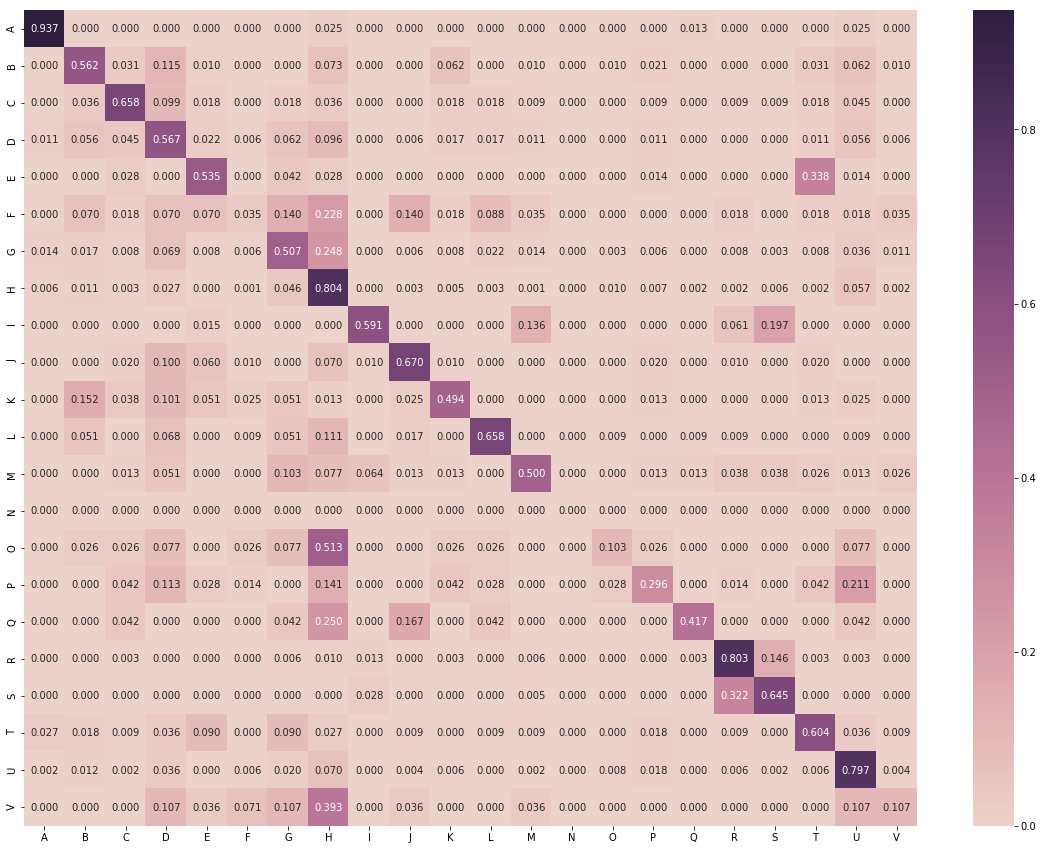

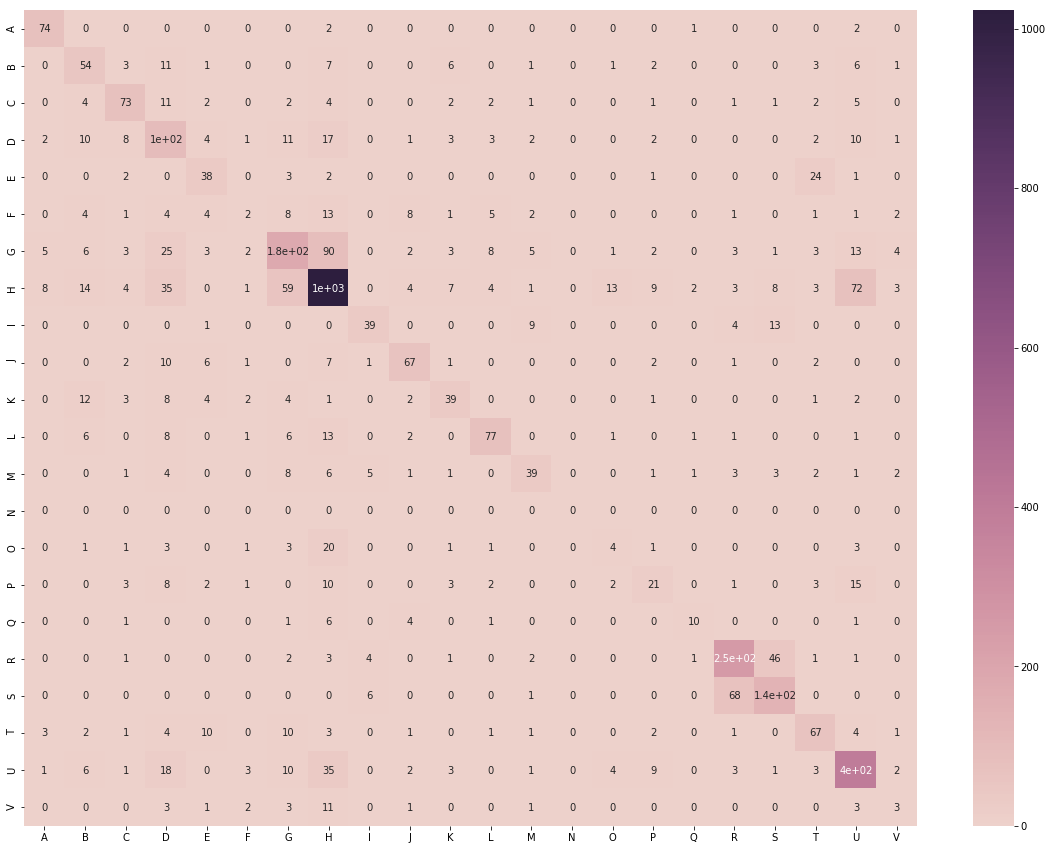

In [67]:
import pandas as pd
import seaborn as sn

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    if a != 0 :
        for j in i:
            tmp_arr.append(float(j)/float(a))
    else :
        for j in i:
            tmp_arr.append(0)
    norm_conf.append(tmp_arr)
    
df_cm = pd.DataFrame(norm_conf, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"],
                     columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"])
plt.figure(figsize = (20,15))
cmap = sn.cubehelix_palette(8, as_cmap=True)
sn.heatmap(df_cm, annot=True, cmap=cmap, fmt='.3f')

df_cm = pd.DataFrame(conf_arr.astype(int), index = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"],
                     columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUV"])
plt.figure(figsize = (20,15))
cmap = sn.cubehelix_palette(8, as_cmap=True)
sn.heatmap(df_cm, annot=True, cmap=cmap)

In [68]:
print cDic

{'CNT_NOT_OPEN_S': 18, 'SD_BOMB': 6, 'PI_UNDERLAYER': 9, 'ACT_HABU_PTN_ER': 10, 'CNT_FILM': 11, 'SD_SPOT': 7, 'PAST_REPAIR': 1, 'GAT2_HABU_PTN_E': 2, 'ILD_FLAKE': 12, 'GAT1_HABU_PTN_E': 3, 'CORROSION': 0, 'PI_UNDER_S': 5, 'BLACK_IMUL': 21, 'BLACK_SPOT': 20, 'PTN_ERR': 15, 'PI_UNDER_K': 13, 'SHORT_D': 19, 'HOLE_PTN_ERR': 17, 'LARVA': 14, 'SHORT_P': 4, 'TI_YUSIL': 16, 'CNT_NOT_OPEN': 8}


In [16]:
tf.reset_default_graph()

In [9]:
sess.close()